In [1]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib import gridspec
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, balanced_accuracy_score, auc, roc_auc_score, log_loss, mean_squared_error
from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from rit.tree import DecisionTreeClassifier as MyDecisionTreeClassifier
from rit.tree import DecisionTreeRegressor as MyDecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from rit.ensemble import RandomForestClassifier as MyRandomForestClassifier
from rit.ensemble import RandomForestRegressor as MyRandomForestRegressor

from mlxtend.plotting import plot_decision_regions
from sklearn.datasets import make_classification, make_regression

from scipy.stats import f_oneway

from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

# Выбор оптимального $\alpha$

## Для бинарной классификации с помощью ROC_AUC_score

In [2]:
def find_optimal_alpha_classification_roc(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    alpha_values = np.linspace(0, 0.99999, 21)

    base_model = MyRandomForestClassifier(max_features='sqrt',
                                    random_state=0,
                                    max_leaf_nodes=2**5,
                                    bootstrap=True,
                                    oob_score=accuracy_score,
                                    n_jobs=1,
                                    rit_alpha=-1e6,
                                    subforest_importance=True,
                                    normalize_importance=False)
    base_model.fit(X_train, y_train)
    y_base_pred = base_model.predict(X_test)

    predictions = [y_base_pred]

    for alpha in alpha_values:
        rit_model = MyRandomForestClassifier(max_features='sqrt',
                                    random_state=0,
                                    max_leaf_nodes=2**5,
                                    bootstrap=True,
                                    oob_score=accuracy_score,
                                    n_jobs=1,
                                    rit_alpha=alpha,
                                    subforest_importance=True,
                                    normalize_importance=False)
        rit_model.fit(X_train, y_train)
        y_modified_pred = rit_model.predict(X_test)

        predictions.append(y_modified_pred)

    roc_scores = []
    for y_pred in predictions:
        roc_scores.append(roc_auc_score(y_test, y_pred))
    threshold = 0.005
    valid_alphas = [alpha for alpha, sc in zip([0] + list(alpha_values), roc_scores) if 1 - sc / roc_scores[0] <= threshold]

    if valid_alphas:
        max_valid_alpha = max(valid_alphas)
        print("Максимальное значение alpha, при котором гипотеза не отвергается:", max_valid_alpha)
        return max_valid_alpha
    else:
        print("Для всех значений alpha гипотеза отвергается.")
    return 0

## Для регрессии с помощью оценки метрики MSE

In [33]:
def find_optimal_alpha_regression_mse(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    alpha_values = np.linspace(0, 0.99999, 21)

    base_model = MyRandomForestRegressor(max_features='sqrt',
                                    random_state=0,
                                    max_leaf_nodes=2**5,
                                    bootstrap=True,
                                    oob_score=mean_squared_error,
                                    n_jobs=1,
                                    rit_alpha=-1e6,
                                    subforest_importance=True,
                                    normalize_importance=False)
    base_model.fit(X_train, y_train)
    y_base_pred = base_model.predict(X_test)

    predictions = [y_base_pred]

    for alpha in alpha_values:
        rit_model = MyRandomForestRegressor(max_features='sqrt',
                                    random_state=0,
                                    max_leaf_nodes=2**5,
                                    bootstrap=True,
                                    oob_score=mean_squared_error,
                                    n_jobs=1,
                                    rit_alpha=alpha,
                                    subforest_importance=True,
                                    normalize_importance=False)
        rit_model.fit(X_train, y_train)
        y_modified_pred = rit_model.predict(X_test)

        predictions.append(y_modified_pred)

    mse_scores = []
    for y_pred in predictions:
        mse_scores.append(mean_squared_error(y_test, y_pred))
    threshold = 0.01
    print(*mse_scores)
    valid_alphas = [alpha for alpha, sc in zip([0] + list(alpha_values), mse_scores) if sc / mse_scores[0] - 1 <= threshold]

    if valid_alphas:
        max_valid_alpha = max(valid_alphas)
        print("Максимальное значение alpha, при котором гипотеза не отвергается:", max_valid_alpha)
        return max_valid_alpha
    else:
        print("Для всех значений alpha гипотеза отвергается.")
    return 0

## Варианты для многоклассовой классификации и регрессии с помощью ANOVA

In [4]:
def find_optimal_alpha_regression_anova(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  alpha_values = np.linspace(0, 0.99999, 21)

  base_model = MyRandomForestRegressor(random_state=0,
                               max_leaf_nodes=2**2,
                               bootstrap=True,
                               max_depth=5,
                               oob_score=mean_squared_error,
                               n_jobs=1,
                               rit_alpha=-1e6,
                               subforest_importance=True,
                               normalize_importance=False,
                               importance_avrg='median')
  base_model.fit(X_train, y_train)
  y_base_pred = base_model.predict(X_test)

  predictions = [y_base_pred]

  for alpha in alpha_values:
      rit_model = MyRandomForestRegressor(random_state=0,
                               max_leaf_nodes=2**2,
                               bootstrap=True,
                               max_depth=5,
                               oob_score=mean_squared_error,
                               n_jobs=1,
                               rit_alpha=alpha,
                               subforest_importance=True,
                               normalize_importance=False,
                               importance_avrg='median')
      rit_model.fit(X_train, y_train)
      y_rit_pred = rit_model.predict(X_test)
      predictions.append(y_rit_pred)

  f_statistic, p_value = f_oneway(*predictions)
  print(f_statistic, p_value)

  threshold = 0.20
  valid_alphas = [alpha for alpha, p in zip([0] + list(alpha_values), [p_value] * len(predictions)) if p >= threshold]

  if valid_alphas:
      max_valid_alpha = max(valid_alphas)
      print("Максимальное значение alpha, при котором гипотеза не отвергается:", max_valid_alpha)
      return max_valid_alpha
  else:
      print("Для всех значений alpha гипотеза отвергается.")
  return 0


In [5]:
def find_optimal_alpha_classification_anova(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  alpha_values = np.linspace(0, 0.99999, 21)

  base_model = MyRandomForestRegressor(max_features='sqrt',
                                random_state=0,
                                max_leaf_nodes=2**3,
                                max_depth=5,
                                bootstrap=True,
                                oob_score=accuracy_score,
                                n_jobs=1,
                                rit_alpha=-1e6,
                                subforest_importance=True,
                                normalize_importance=False)
  base_model.fit(X_train, y_train)
  y_base_pred = base_model.predict(X_test)

  predictions = [y_base_pred]

  for alpha in alpha_values:
      rit_model = MyRandomForestClassifier(max_features='sqrt',
                                random_state=0,
                                max_leaf_nodes=2**3,
                                max_depth=5,
                                bootstrap=True,
                                oob_score=accuracy_score,
                                n_jobs=1,
                                rit_alpha=alpha,
                                subforest_importance=True,
                                normalize_importance=False)
      rit_model.fit(X_train, y_train)
      y_modified_pred = rit_model.predict(X_test)

      predictions.append(y_modified_pred)

  f_statistic, p_value = f_oneway(*predictions)
  print(f_statistic, p_value)
  threshold = 0.20
  valid_alphas = [alpha for alpha, p in zip([0] + list(alpha_values), [p_value] * len(predictions)) if p >= threshold]

  if valid_alphas:
      max_valid_alpha = max(valid_alphas)
      print("Максимальное значение alpha, при котором гипотеза не отвергается:", max_valid_alpha)
      return max_valid_alpha
  else:
      print("Для всех значений alpha гипотеза отвергается.")
  return 0

# Генерация выборок

## Функции визуализации

In [6]:
np.random.seed(0)

In [7]:
def Visualise_classification_2D(X, y):
  cols = ['blue', 'red', 'green', 'yellow']
  plt.figure(figsize=(9,4))
  plt.xlim((np.min(X) - 0.5, np.max(X) + 0.5)),
  plt.ylim((np.min(X) - 0.5, np.max(X) + 0.5))

  for k in np.unique(y):
      plt.plot(X[y==k,0], X[y==k,1], 'o',
                label='класс {}'.format(k), color=cols[k])

  plt.legend(loc='best')
  plt.xlabel('x1')
  plt.ylabel('x2')
  plt.show()

In [8]:
def Visualise_regression_2D(X, y, xlim, ylim):
  plt.figure(figsize=[9, 4])
  plt.xlim((xlim[0], xlim[1]))
  plt.ylim((ylim[0], ylim[1]))

  sc = plt.scatter(X[:, 0], X[:, 1], c=y, s=5)

  plt.colorbar(sc)

  plt.xlabel('x1')
  plt.ylabel('x2')
  plt.show()

## Классификация

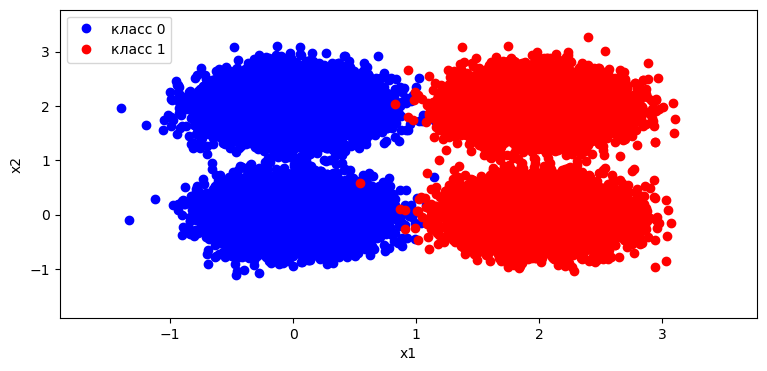

In [9]:
def data_classification_2D_1():
  n = 2
  l = 100 ** n
  X1 = np.array([[0,0]]) + 0.3*np.random.randn(l, n)
  X2 = np.array([[0,2]]) + 0.3*np.random.randn(l, n)
  X3 = np.array([[2,0]]) + 0.3*np.random.randn(l, n)
  X4 = np.array([[2,2]]) + 0.3*np.random.randn(l, n)

  X = np.vstack([X1, X2, X3, X4])
  y = np.hstack([[0]*l, [0]*l, [1]*l, [1]*l])

  return X, y

X, y = data_classification_2D_1()
Visualise_classification_2D(X, y)

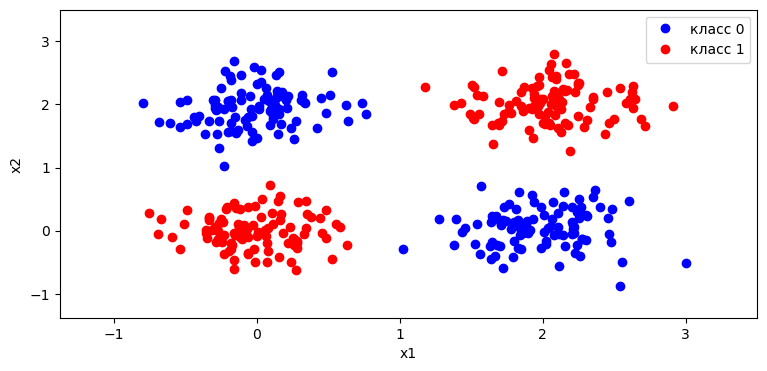

In [10]:
def data_classification_2D_2():
  n = 2
  l = 10 ** n
  X1 = np.array([[0,0]]) + 0.3*np.random.randn(l, n)
  X2 = np.array([[0,2]]) + 0.3*np.random.randn(l, n)
  X3 = np.array([[2,0]]) + 0.3*np.random.randn(l, n)
  X4 = np.array([[2,2]]) + 0.3*np.random.randn(l, n)

  X = np.vstack([X1, X2, X3, X4])
  y = np.hstack([[1]*l, [0]*l, [0]*l, [1]*l])

  return X, y

X, y = data_classification_2D_2()
Visualise_classification_2D(X, y)

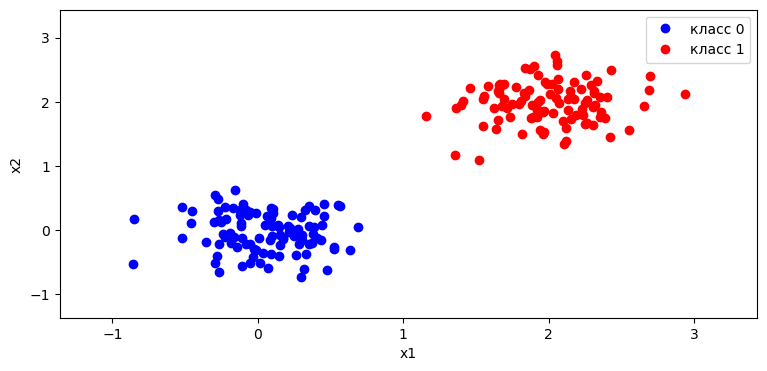

In [11]:
def data_classification_2D_3():
  n = 2
  l = 10 ** n
  X1 = np.array([[0,0]]) + 0.3*np.random.randn(l, n)
  X2 = np.array([[2,2]]) + 0.3*np.random.randn(l, n)

  X = np.vstack([X1, X2])
  y = np.hstack([[0]*l, [1]*l])

  return X, y

X, y = data_classification_2D_3()
Visualise_classification_2D(X, y)

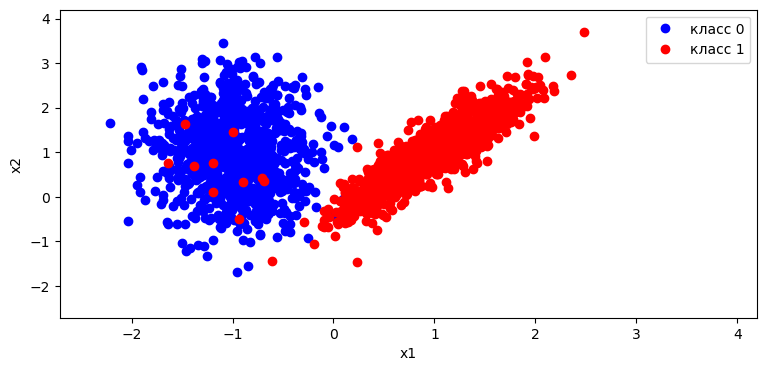

In [12]:
def data_classification_2D_4():
  X, y = make_classification(n_samples=2001, n_features=2,
                            n_informative=2, n_classes=2,
                            n_redundant=0,
                            n_clusters_per_class=1,
                            random_state=0)
  return X, y

X, y = data_classification_2D_4()
Visualise_classification_2D(X, y)

In [13]:
def data_classification_2D_5():
  X, y = make_classification(n_samples=2000, n_features=3,
                            n_informative=2, n_classes=2,
                            n_redundant=0,
                            n_clusters_per_class=1,
                            random_state=3)
  return X, y

In [14]:
def data_classification_2D_6():
  X, y = make_classification(n_samples=10000, n_features=10,
                            n_informative=10, n_classes=2,
                            n_redundant=0,
                            n_clusters_per_class=1,
                            random_state=0)
  return X, y

## Регрессия

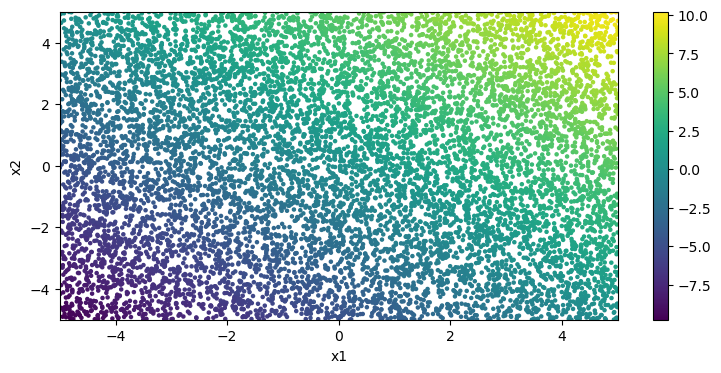

In [15]:
def data_regression_2D_1():
  n = 2
  N = 100**n

  X1 = np.random.uniform(-5, 5, N)
  X2 = np.random.uniform(-5, 5, N)

  y = X1 + X2 + np.random.random(N)/3
  X = np.vstack([X1, X2]).transpose(1, 0)

  return X, y

X, y = data_regression_2D_1()
Visualise_regression_2D(X, y, (-5, 5), (-5, 5))

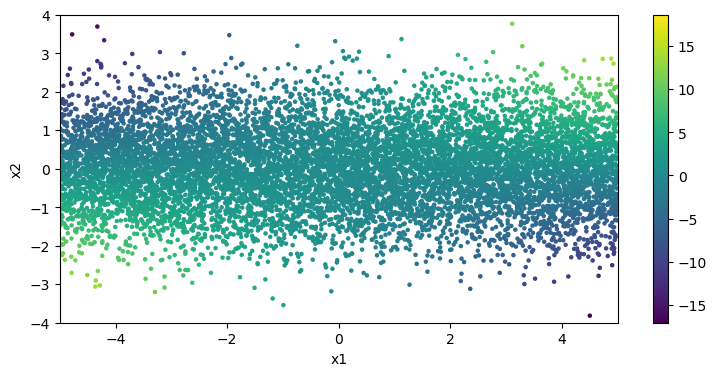

In [16]:
def data_regression_2D_2():
  n = 2
  N = 100**n

  X1 = np.random.uniform(-5, 5, N)
  X2 = np.random.normal(0, 1, N)

  y = X1 * X2 + np.random.random(N)/3
  X = np.vstack([X1, X2]).transpose(1, 0)

  return X, y

X, y = data_regression_2D_2()
Visualise_regression_2D(X, y, (-5, 5), (-4, 4))

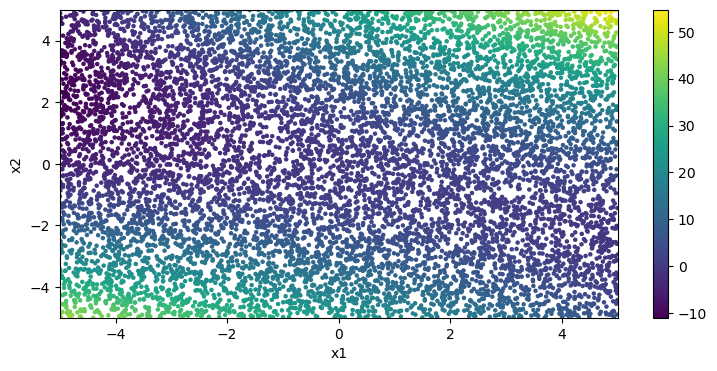

In [17]:
def data_regression_2D_3():
  n = 2
  N = 100**n

  X1 = np.random.uniform(-5, 5, N)
  X2 = np.random.uniform(-5, 5, N)

  y = X1 + X1 * X2 + X2**2 + np.random.random(N)/3
  X = np.vstack([X1, X2]).transpose(1, 0)

  return X, y

X, y = data_regression_2D_3()
Visualise_regression_2D(X, y, (-5, 5), (-5, 5))

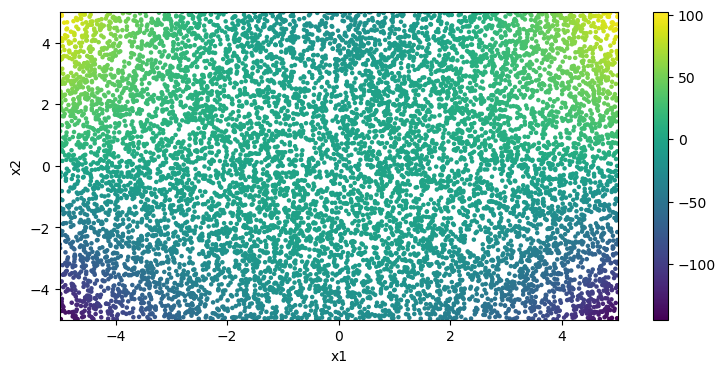

In [18]:
def data_regression_2D_4():
  n = 2
  N = 100**n

  X1 = np.random.uniform(-5, 5, N)
  X2 = np.random.uniform(-5, 5, N)

  y = np.log(np.abs(X1 * X2)) + X1 ** 2 * X2 - X2**2 + np.random.random(N)/3
  X = np.vstack([X1, X2]).transpose(1, 0)

  return X, y

X, y = data_regression_2D_4()
Visualise_regression_2D(X, y, (-5, 5), (-5, 5))

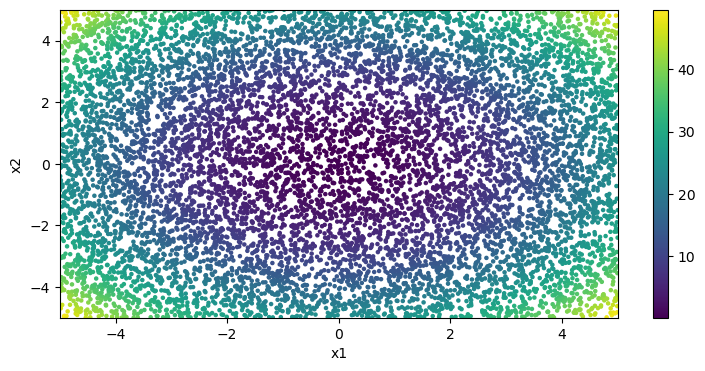

In [19]:
def data_regression_2D_5():
  n = 2
  N = 100**n

  X1 = np.random.uniform(-5, 5, N)
  X2 = np.random.uniform(-5, 5, N)

  y = X1 ** 2 + X2**2 + np.random.random(N)/3
  X = np.vstack([X1, X2]).transpose(1, 0)

  return X, y

X, y = data_regression_2D_5()
Visualise_regression_2D(X, y, (-5, 5), (-5, 5))

# Методы оценки взаимодействия признаков

## Структура отдельного дерева

In [20]:
def draw_tree(tree, feature_names):
    n_nodes = tree.tree_.node_count
    children_left = tree.tree_.children_left
    children_right = tree.tree_.children_right
    feature = tree.tree_.feature
    threshold = tree.tree_.threshold
    values = tree.tree_.value

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, 0)]
    while len(stack) > 0:
        node_id, depth = stack.pop()
        node_depth[node_id] = depth
        is_split_node = children_left[node_id] != children_right[node_id]
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            is_leaves[node_id] = True

    print(
        "The binary tree structure has {n} nodes and has "
        "the following tree structure:\n".format(n=n_nodes)
    )
    for i in range(n_nodes):
        if is_leaves[i]:
            print(
                "{space}node={node} is a leaf node with value={value}.".format(
                    space=node_depth[i] * "\t", node=i, value=np.around(values[i], 3)
                )
            )
        else:
            print(
                "{space}node={node} is a split node with value={value}: "
                "go to node {left} if {feature} <= {threshold} "
                "else to node {right}.".format(
                    space=node_depth[i] * "\t",
                    node=i,
                    left=children_left[i],
                    feature=feature_names[feature[i]],
                    threshold=threshold[i],
                    right=children_right[i],
                    value=np.around(values[i], 3),
                )
            )

## Матрицы

1. В матрицу A записываются очки за то, что признак идёт после другого признака. Если j-й признак является ребёнком i-ого, то $a_{ij} += 1$.

In [21]:
def dependency_matrix_tree_ver_1(tree, n_features):
    matrix = np.zeros((n_features,  n_features))

    n_nodes = tree.tree_.node_count
    children_left = tree.tree_.children_left
    children_right = tree.tree_.children_right
    feature = tree.tree_.feature
    threshold = tree.tree_.threshold
    values = tree.tree_.value

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)

    stack = [(0, 0)]
    while len(stack) > 0:
        node_id, depth = stack.pop()
        node_depth[node_id] = depth
        is_split_node = children_left[node_id] != children_right[node_id]
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
            matrix[feature[node_id]][feature[children_left[node_id]]] += 1
            matrix[feature[node_id]][feature[children_right[node_id]]] += 1
        else:
            is_leaves[node_id] = True
    return matrix / (n_nodes - 1)

2. Теперь учитывается глубина, на которой произошла смена признака. Эвристика: чем раньше произошла смена, тем более скоррелированы признаки.

In [22]:
def dependency_matrix_tree_ver_2(tree, n_features, func = lambda x: 1 / 2 ** x):

    matrix = np.zeros((n_features,  n_features))

    n_nodes = tree.tree_.node_count
    children_left = tree.tree_.children_left
    children_right = tree.tree_.children_right
    feature = tree.tree_.feature
    threshold = tree.tree_.threshold
    values = tree.tree_.value

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)

    stack = [(0, 0)]
    while len(stack) > 0:
        node_id, depth = stack.pop()
        node_depth[node_id] = depth
        is_split_node = children_left[node_id] != children_right[node_id]
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
            matrix[feature[node_id]][feature[children_left[node_id]]] += func(depth)
            matrix[feature[node_id]][feature[children_right[node_id]]] += func(depth)
        else:
            is_leaves[node_id] = True
    return matrix / (n_nodes - 1)

3. Теперь будем учитывать коэффициент $\alpha$. Эвристика: чем больше $α$, тем сложнее новому признаку пробиться, следовательно корреляция увеличивается.

In [23]:
def dependency_matrix_tree_ver_3(tree, n_features, alpha,  func = lambda x: 1 / 2 ** x, func2 = lambda a: 1 + a):
    matrix = np.zeros((n_features,  n_features))

    n_nodes = tree.tree_.node_count
    children_left = tree.tree_.children_left
    children_right = tree.tree_.children_right
    feature = tree.tree_.feature
    threshold = tree.tree_.threshold
    values = tree.tree_.value

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)

    stack = [(0, 0)]
    while len(stack) > 0:
        node_id, depth = stack.pop()
        node_depth[node_id] = depth
        is_split_node = children_left[node_id] != children_right[node_id]
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
            matrix[feature[node_id]][feature[children_left[node_id]]] += func(depth) * func2(alpha)
            matrix[feature[node_id]][feature[children_right[node_id]]] += func(depth) * func2(alpha)
        else:
            is_leaves[node_id] = True
    return matrix / (n_nodes - 1)

Функция, применяющая выбранную модель матрицы

In [24]:
def dependency_matrix_forest(model, n_features, alpha):
  matrix = np.zeros((n_features,  n_features))

  for tree in model.estimators_:
    matrix += dependency_matrix_tree_ver_1(tree, n_features)

  N = model.n_estimators
  matrix = matrix / N

  return matrix

# Проверка модели на сгенерированных данных

## Вспомогательные функции

In [25]:
def Visualise_FI(model):
  plt.figure()
  pd.Series(model.feature_importances_).sort_values(ascending=True).plot(kind='barh')
  xtl = plt.gca().get_xticklabels()
  plt.gca().set_xticklabels(xtl, fontsize=15)
  plt.gca().set_title('RF', fontsize=15)
  plt.show()

In [74]:
def fit_classification(X, y, score_func = accuracy_score):
  # alpha = find_optimal_alpha_classification_roc(X, y)
  alpha = 0.3
  rf = MyRandomForestClassifier(max_features='sqrt',
                                random_state=0,
                                max_leaf_nodes=2**5,
                                bootstrap=True,
                                oob_score=score_func,
                                n_jobs=1,
                                rit_alpha=0.3,
                                subforest_importance=True,
                                normalize_importance=False)
  rf.fit(X, y)
  Visualise_FI(rf)
  return dependency_matrix_forest(rf, len(X[0]), alpha)


In [96]:
def fit_regression(X, y, score_func = mean_squared_error):
  # alpha = find_optimal_alpha_regression_mse(X, y)
  alpha = 0.3
  rf = MyRandomForestRegressor(random_state=0,
                               max_leaf_nodes=2**5,
                               bootstrap=True,
                               oob_score=score_func,
                               n_jobs=1,
                               rit_alpha=0.3,
                               subforest_importance=True,
                               normalize_importance=False,
                               importance_avrg='median')
  rf.fit(X, y)
  # Visualise_FI(rf)
  return dependency_matrix_forest(rf, len(X[0]), alpha)

## Классификация

/tmp/ipykernel_17430/1239972757.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(xtl, fontsize=15)


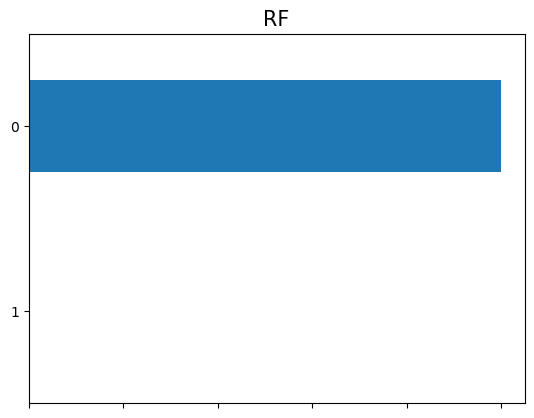

[[0.80723582 0.0365811 ]
 [0.13103923 0.02514384]]


In [76]:
X, y = data_classification_2D_1()
matrix_classification_1 = fit_classification(X, y)
print(matrix_classification_1)

/tmp/ipykernel_17430/1239972757.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(xtl, fontsize=15)


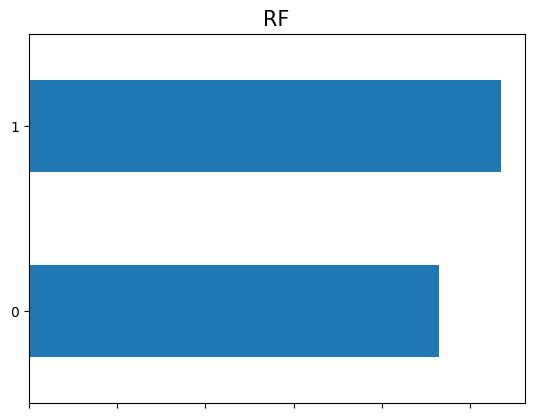

[[0.35652848 0.13334907]
 [0.40629414 0.1038283 ]]


In [77]:
X, y = data_classification_2D_2()
matrix_classification_2 = fit_classification(X, y)
print(matrix_classification_2)

/tmp/ipykernel_17430/1239972757.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(xtl, fontsize=15)


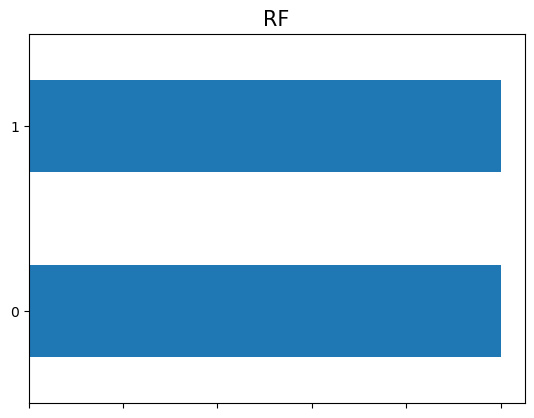

[[0.49 0.  ]
 [0.51 0.  ]]


In [78]:
X, y = data_classification_2D_3()
matrix_classification_3 = fit_classification(X, y)
print(matrix_classification_3)

/tmp/ipykernel_17430/1239972757.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(xtl, fontsize=15)


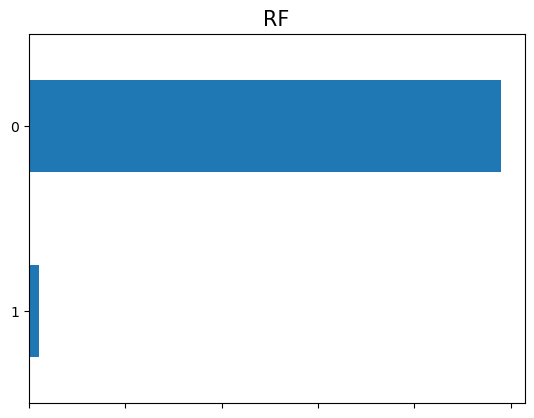

[[0.74774033 0.05801773]
 [0.16346243 0.03077951]]


In [79]:
X, y = data_classification_2D_4()
matrix_classification_4 = fit_classification(X, y)
print(matrix_classification_4)

/tmp/ipykernel_17430/1239972757.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(xtl, fontsize=15)


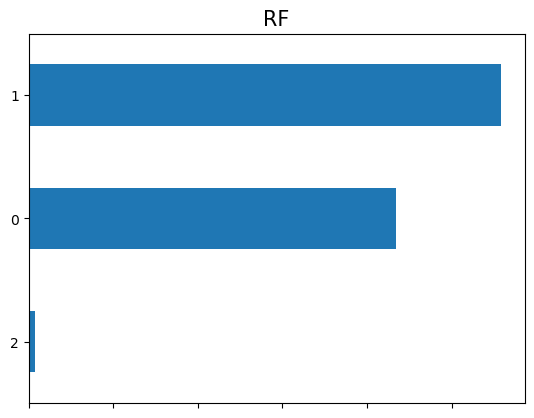

[[0.11709677 0.33903226 0.00903226]
 [0.10032258 0.37532258 0.00854839]
 [0.01032258 0.03693548 0.0033871 ]]


In [80]:
X, y = data_classification_2D_5()
matrix_classification_5 = fit_classification(X, y)
print(matrix_classification_5)

/tmp/ipykernel_17430/1239972757.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(xtl, fontsize=15)


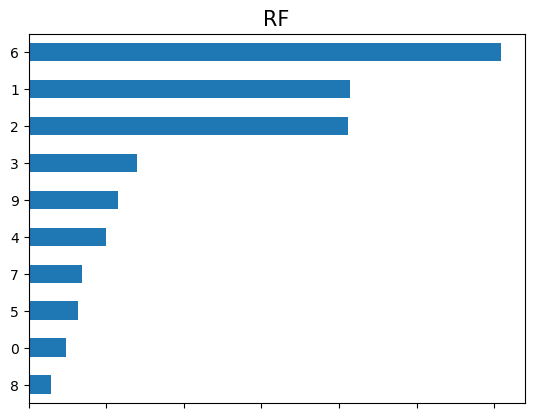

[[0.00016129 0.00225806 0.00048387 0.0016129  0.00112903 0.
  0.00177419 0.00080645 0.02693548 0.00064516]
 [0.00274194 0.00887097 0.02112903 0.005      0.00967742 0.00903226
  0.01645161 0.00822581 0.07467742 0.01354839]
 [0.00290323 0.0233871  0.01258065 0.00629032 0.00854839 0.00693548
  0.02129032 0.01       0.0666129  0.00435484]
 [0.00580645 0.00548387 0.00548387 0.00274194 0.00580645 0.00145161
  0.00870968 0.00370968 0.0766129  0.00387097]
 [0.00064516 0.00709677 0.00419355 0.00290323 0.0016129  0.00451613
  0.00758065 0.0033871  0.06145161 0.00177419]
 [0.00016129 0.00370968 0.00483871 0.00048387 0.00274194 0.00048387
  0.00403226 0.00145161 0.03870968 0.00177419]
 [0.00145161 0.01354839 0.01983871 0.03387097 0.00774194 0.00451613
  0.02145161 0.00451613 0.07       0.01209677]
 [0.00241935 0.00709677 0.00403226 0.00322581 0.00354839 0.00032258
  0.00274194 0.00048387 0.04629032 0.00241935]
 [0.00016129 0.00064516 0.00080645 0.         0.00048387 0.00032258
  0.00064516 0.00032

In [81]:
X, y = data_classification_2D_6()
matrix_classification_6 = fit_classification(X, y)
print(matrix_classification_6)

## Регрессия

$y = x_1 + x_2$

/tmp/ipykernel_17430/1239972757.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(xtl, fontsize=15)


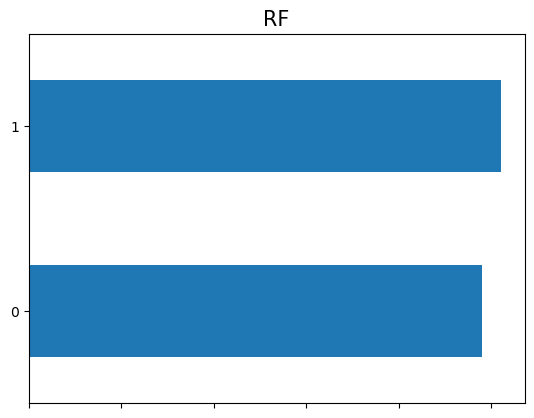

[[0.27241935 0.21693548]
 [0.4833871  0.02725806]]


In [85]:
X, y = data_regression_2D_1()
matrix_regression_1 = fit_regression(X, y)
print(matrix_regression_1)

$y = x_1 \cdot x_2$

/tmp/ipykernel_17430/1239972757.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(xtl, fontsize=15)


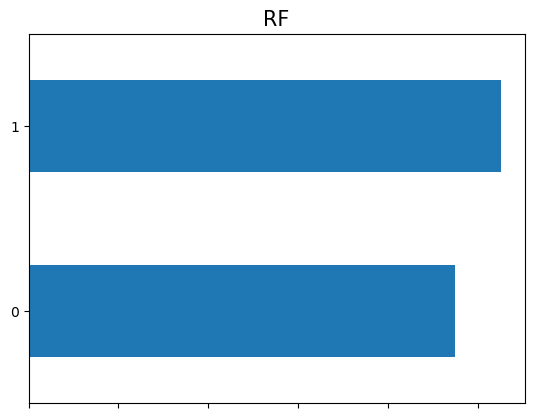

[[0.35806452 0.09870968]
 [0.38564516 0.15758065]]


In [86]:
X, y = data_regression_2D_2()
matrix_regression_2 = fit_regression(X, y)
print(matrix_regression_2)

$y = x_1 + x_1 \cdot x_2 + x_2^2$

/tmp/ipykernel_17430/1239972757.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(xtl, fontsize=15)


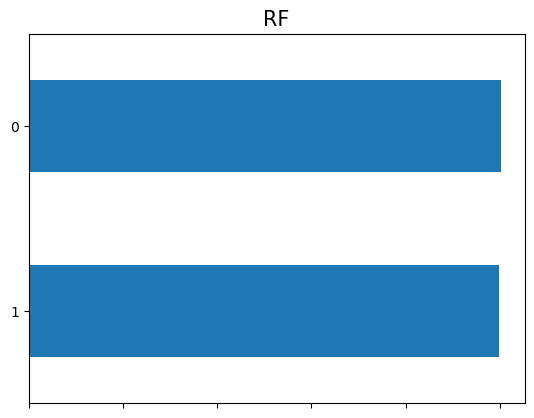

[[0.39822581 0.14403226]
 [0.38903226 0.06870968]]


In [87]:
X, y = data_regression_2D_3()
matrix_regression_3 = fit_regression(X, y)
print(matrix_regression_3)

$y = ln(|x_1 \cdot x_2|) + x_1^2 \cdot x_2 - x_2^2$

/tmp/ipykernel_17430/1239972757.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(xtl, fontsize=15)


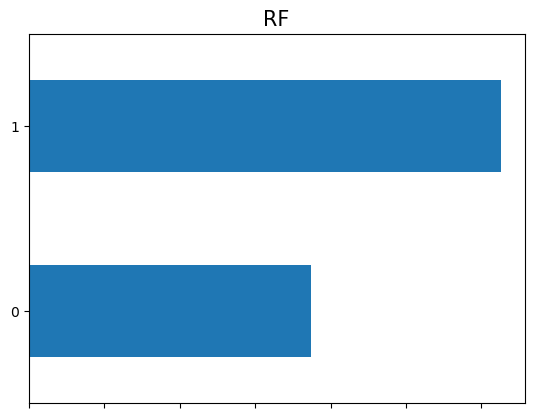

[[0.53903226 0.10032258]
 [0.29677419 0.06387097]]


In [88]:
X, y = data_regression_2D_4()
matrix_regression_4 = fit_regression(X, y)
print(matrix_regression_4)

$y = x_1^2 + x_2^2$

/tmp/ipykernel_17430/1239972757.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(xtl, fontsize=15)


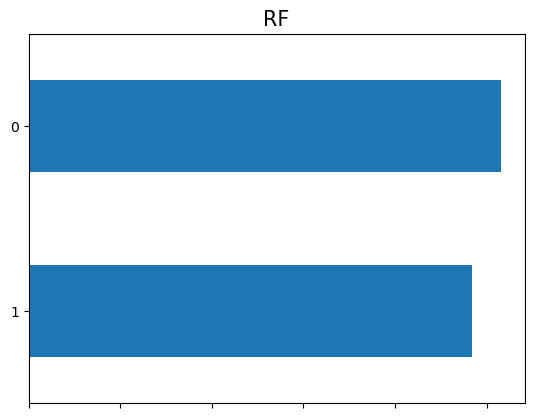

[[0.32177419 0.135     ]
 [0.41177419 0.13145161]]


In [89]:
X, y = data_regression_2D_5()
matrix_regression_5 = fit_regression(X, y)
print(matrix_regression_5)

# TEST

In [ ]:
print(matrix_classification_1[0][1] / matrix_classification_1[1][0])
print(matrix_classification_2[0][1] / matrix_classification_2[1][0])
print(matrix_classification_3[0][1] / matrix_classification_3[1][0])
print(matrix_classification_4[0][1] / matrix_classification_4[1][0])

0.27916142101350777
0.32820820555212865
0.0
0.35493004864506217
3.37942122186495


In [92]:
print(matrix_regression_1[0][1] / matrix_regression_1[1][0])
print(matrix_regression_2[0][1] / matrix_regression_2[1][0])
print(matrix_regression_3[0][1] / matrix_regression_3[1][0])
print(matrix_regression_4[0][1] / matrix_regression_4[1][0])
print(matrix_regression_5[0][1] / matrix_regression_5[1][0])

0.44878211544878216
0.25595984943538297
0.37023217247097845
0.33804347826087017
0.3278495887191541


In [97]:
def func(k):
  n = 2
  N = 100 * k

  X1 = np.random.uniform(-5, 5, N)
  X2 = np.random.uniform(-5, 5, N)

  y = X1 * X2 + np.random.random(N)/3
  X = np.vstack([X1, X2]).transpose(1, 0)

  matr = fit_regression(X, y)

  return matr[0][1] / matr[1][0]

In [101]:
def func_2(k):
  n = 2
  N = 100 * k

  X1 = np.random.uniform(-5, 5, N)
  X2 = np.random.uniform(-5, 5, N)

  y = X1 + X2 + np.random.random(N)/3
  X = np.vstack([X1, X2]).transpose(1, 0)

  matr = fit_regression(X, y)

  return matr[0][1] / matr[1][0]

In [104]:
def func_3(k):
  n = 2
  N = 100 * k

  X1 = np.random.uniform(-5, 5, N)
  X2 = np.random.uniform(-5, 5, N)

  y = np.sin(X1 * X2) + np.random.random(N)/3
  X = np.vstack([X1, X2]).transpose(1, 0)

  matr = fit_regression(X, y)

  return matr[0][1] / matr[1][0]

In [110]:
def func_init(X, y, alpha):
  rf = MyRandomForestRegressor(random_state=0,
                               max_leaf_nodes=2**5,
                               bootstrap=True,
                               oob_score=mean_squared_error,
                               n_jobs=1,
                               rit_alpha=alpha,
                               subforest_importance=True,
                               normalize_importance=False,
                               importance_avrg='median')
  rf.fit(X, y)
  matr = dependency_matrix_forest(rf, len(X[0]), alpha)
  return  matr[0][1] / matr[1][0]

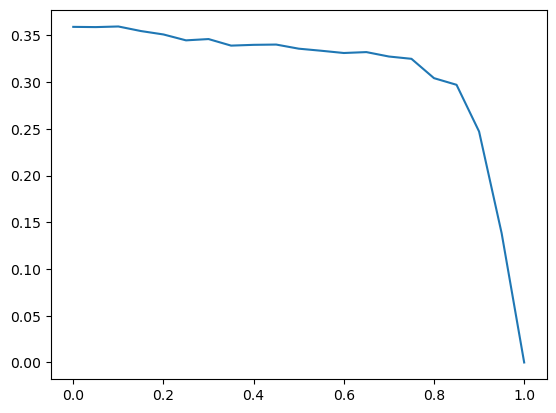

In [111]:
n = 2
N = 100 * 10

X1 = np.random.uniform(-5, 5, N)
X2 = np.random.uniform(-5, 5, N)

y = X1 * X2 + np.random.random(N)/3
X = np.vstack([X1, X2]).transpose(1, 0)
alphas = np.linspace(0, 0.9999, 21)
arr_4 = []
for alpha in alphas:
    arr_4.append(func_init(X, y, alpha))
plt.plot(alphas, arr_4)
plt.show()

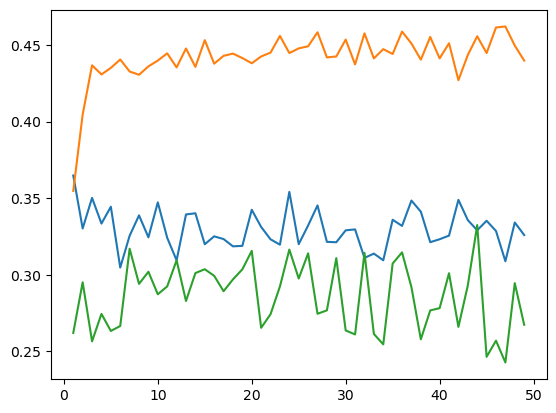

In [105]:
arr_1 = []
arr_2 = []
arr_3 = []
for k in range(1, 50):
    arr_1.append(func(k))
    arr_2.append(func_2(k))
    arr_3.append(func_3(k))

plt.plot(range(1,50), arr_1)
plt.plot(range(1,50), arr_2)
plt.plot(range(1,50), arr_3)
plt.show()